# 하이브리드 머신러닝 모델 (khj + kys)

## 목표
- 판매량 기반 차등 임계값 타겟 정의 + kys의 풍부한 피처
  - Group A (상위 25%): 75% 분위수 (관대)
  - Group B (25.1~50%): 90% 분위수 (엄격)
- 13개 피처: khj 3개 + kys 6개 + 상호작용 4개
- 10-Fold CV + Train/Test Split 이중 평가
- Threshold 최적화 (Recall >= 0.6)
- 메일링 시스템(kys_Mailing.py) 호환 CSV 생성

## 출력
- `kys/Result/risk_report_result.csv` (seller_id, y_pred_proba, 주요_위험사유)


---
## 1. 라이브러리 임포트


In [34]:
import pandas as pd
import numpy as np
import warnings
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import (StratifiedKFold, cross_validate, 
                                    train_test_split)
from sklearn.metrics import (confusion_matrix, classification_report, 
                             precision_score, recall_score, f1_score,
                             accuracy_score)
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)


---
## 2. 데이터 로드 및 필터링


In [35]:
df_raw = pd.read_csv('../Olist_DataSet/merged_olist.csv')

In [36]:
# 필터링 로직: 물류사 과실이더라도 판매자 과실이 있으면 포함
# is_logistics_fault == False: 물류사 과실 아님
# seller_delay_days > 0: 판매자가 shipping_limit_date 초과 (판매자 과실)

df = df_raw[
    (df_raw['is_logistics_fault'] == False) | 
    (df_raw['seller_delay_days'] > 0)         
].copy()

print("="*80)
print("데이터 필터링 결과")
print("="*80)
print(f"전체 데이터: {len(df_raw):,}건")
print(f"물류사 과실: {(df_raw['is_logistics_fault']==True).sum():,}건")
print(f"판매자 과실: {(df_raw['seller_delay_days']>0).sum():,}건")
print(f"양쪽 모두 과실: {((df_raw['is_logistics_fault']==True) & (df_raw['seller_delay_days']>0)).sum():,}건")
print(f"\n필터링 후: {len(df):,}건")
print(f"제외된 건수: {len(df_raw) - len(df):,}건 (순수 물류사 과실만 제외)")


데이터 필터링 결과
전체 데이터: 64,850건
물류사 과실: 2,464건
판매자 과실: 5,535건
양쪽 모두 과실: 1,050건

필터링 후: 63,436건
제외된 건수: 1,414건 (순수 물류사 과실만 제외)


---
## 3. 기본 전처리


In [37]:
# prep_time 계산
df['order_approved_at'] = pd.to_datetime(df['order_approved_at'])
df['order_delivered_carrier_date'] = pd.to_datetime(df['order_delivered_carrier_date'])
df['prep_time'] = (
    df['order_delivered_carrier_date'] - df['order_approved_at']
).dt.total_seconds() / 86400

print("prep_time 계산 완료")
print(f"평균 prep_time: {df['prep_time'].mean():.2f}일")


prep_time 계산 완료
평균 prep_time: 2.71일


In [38]:
# 텍스트 리뷰에서 지연 키워드 추출
delay_keywords = ['atraso', 'demora', 'lento', 'esperar', 'prazo', 'não recebi', 'nao recebi', 'cadê', 'cade', 'entrega',
    'atraso', 'chegou', 'ainda não', 'ainda nao', 'onde está']

df['has_delay_comment'] = df['review_comment_message'].fillna('').apply(
    lambda x: 1 if any(word in x.lower() for word in delay_keywords) else 0
)

print("지연 키워드 추출 완료")
print(f"지연 키워드 포함 리뷰: {df['has_delay_comment'].sum():,}건 ({df['has_delay_comment'].mean()*100:.2f}%)")


지연 키워드 추출 완료
지연 키워드 포함 리뷰: 10,810건 (17.04%)


In [39]:
# 이진 변수 생성
df['is_processing_delayed'] = (df['processing_days_diff'] > 0).astype(int)
df['is_seller_delayed'] = (df['seller_delay_days'] > 0).astype(int)
df['is_negative_review'] = (df['review_score'] <= 3).astype(int)
df['is_critical_complaint'] = (
    (df['review_score'] <= 3) & (df['has_text_review'] == True)
).astype(int)

print("이진 변수 생성 완료")
print(f"처리지연: {df['is_processing_delayed'].sum():,}건 ({df['is_processing_delayed'].mean()*100:.1f}%)")
print(f"출고지연: {df['is_seller_delayed'].sum():,}건 ({df['is_seller_delayed'].mean()*100:.1f}%)")
print(f"부정리뷰: {df['is_negative_review'].sum():,}건 ({df['is_negative_review'].mean()*100:.1f}%)")
print(f"심각불만: {df['is_critical_complaint'].sum():,}건 ({df['is_critical_complaint'].mean()*100:.1f}%)")


이진 변수 생성 완료
처리지연: 22,058건 (34.8%)
출고지연: 5,535건 (8.7%)
부정리뷰: 12,332건 (19.4%)
심각불만: 8,202건 (12.9%)


---
## 4. 판매자별 집계


In [40]:
# 판매자별 집계 (시계열 없음)
seller_stats = df.groupby('seller_id').agg({
    'has_delay_comment': 'mean',              # text_review_ratio
    'order_id': 'nunique',                    # order_count
    'review_score': 'mean',                   # avg_review_score
    'is_processing_delayed': 'mean',          # processing_delay_rate
    'is_seller_delayed': 'mean',              # seller_delay_rate
    'is_negative_review': 'mean',             # negative_review_rate
    'is_critical_complaint': 'mean',          # critical_complaint_rate
    'seller_processing_days': ['mean', 'std'] # processing_days_mean/std
}).reset_index()

# 컬럼명 정리
seller_stats.columns = [
    'seller_id',
    'text_review_ratio',
    'order_count',
    'avg_review_score',
    'processing_delay_rate',
    'seller_delay_rate',
    'negative_review_rate',
    'critical_complaint_rate',
    'processing_days_mean',
    'processing_days_std'
]

# NaN 처리
seller_stats = seller_stats.fillna(0)

print("="*80)
print("판매자별 집계 완료")
print("="*80)
print(f"판매자 수: {len(seller_stats):,}명")
print(f"\n[피처별 평균]")
print(f"  text_review_ratio:      {seller_stats['text_review_ratio'].mean():.4f}")
print(f"  order_count:            {seller_stats['order_count'].mean():.1f}")
print(f"  avg_review_score:       {seller_stats['avg_review_score'].mean():.2f}")
print(f"  processing_delay_rate:  {seller_stats['processing_delay_rate'].mean():.4f}")
print(f"  seller_delay_rate:      {seller_stats['seller_delay_rate'].mean():.4f}")
print(f"  negative_review_rate:   {seller_stats['negative_review_rate'].mean():.4f}")


판매자별 집계 완료
판매자 수: 2,661명

[피처별 평균]
  text_review_ratio:      0.1719
  order_count:            21.1
  avg_review_score:       4.27
  processing_delay_rate:  0.3691
  seller_delay_rate:      0.1115
  negative_review_rate:   0.1801


---
## 5. 피처 엔지니어링 (상호작용 4개 추가)


In [41]:
# 상호작용 피처 생성 (4개)
seller_stats['delay_negative_interaction'] = (
    seller_stats['seller_delay_rate'] * seller_stats['negative_review_rate']
)

seller_stats['processing_seller_delay_interaction'] = (
    seller_stats['processing_delay_rate'] * seller_stats['seller_delay_rate']
)

seller_stats['total_risk_score'] = (
    seller_stats['processing_delay_rate'] + 
    seller_stats['seller_delay_rate'] + 
    seller_stats['negative_review_rate']
)

seller_stats['avg_delay_rate'] = (
    seller_stats['processing_delay_rate'] + 
    seller_stats['seller_delay_rate']
) / 2

print("상호작용 피처 생성 완료")
print(f"총 피처 수: {len(seller_stats.columns) - 1}개 (seller_id 제외)")
print("\n[13개 피처 구성]")
print("  khj (3개): text_review_ratio, order_count, avg_review_score")
print("  kys (6개): processing_delay_rate, seller_delay_rate, negative_review_rate,")
print("            critical_complaint_rate, processing_days_mean, processing_days_std")
print("  상호작용 (4개): delay_negative_interaction, processing_seller_delay_interaction,")
print("                 total_risk_score, avg_delay_rate")


상호작용 피처 생성 완료
총 피처 수: 13개 (seller_id 제외)

[13개 피처 구성]
  khj (3개): text_review_ratio, order_count, avg_review_score
  kys (6개): processing_delay_rate, seller_delay_rate, negative_review_rate,
            critical_complaint_rate, processing_days_mean, processing_days_std
  상호작용 (4개): delay_negative_interaction, processing_seller_delay_interaction,
                 total_risk_score, avg_delay_rate


---
## 6. 타겟 정의 (판매량 기반 차등 임계값)

### 비즈니스 로직
- **Group A (상위 25%)**: 초대형 판매자 → 75% 분위수 (관대)
- **Group B (25.1~50%)**: 중대형 판매자 → 90% 분위수 (엄격)


In [42]:
# 판매량 기준으로 그룹 분할
# 상위 25% (75% 분위수): Group A (초대형 판매자)
# 25.1~50% (50% 분위수): Group B (중대형 판매자)

quantile_25 = seller_stats['order_count'].quantile(0.75)  # 상위 25%
quantile_50 = seller_stats['order_count'].quantile(0.50)  # 상위 50%

print("="*80)
print("그룹 분할 기준 (판매량)")
print("="*80)
print(f"전체 판매자: {len(seller_stats):,}명")
print(f"상위 25% 기준: {quantile_25:.0f}건 이상")
print(f"상위 50% 기준: {quantile_50:.0f}건 이상")


그룹 분할 기준 (판매량)
전체 판매자: 2,661명
상위 25% 기준: 16건 이상
상위 50% 기준: 5건 이상


In [43]:
# Group A: 상위 25% (초대형 판매자) - 75% 분위수 임계값
group_a = seller_stats[seller_stats['order_count'] >= quantile_25].copy()

thresholds_a = {
    'processing_delay_rate': group_a['processing_delay_rate'].quantile(0.75),
    'seller_delay_rate': group_a['seller_delay_rate'].quantile(0.75),
    'negative_review_rate': group_a['negative_review_rate'].quantile(0.75)
}

group_a['is_Seller_of_Note'] = (
    (group_a['processing_delay_rate'] >= thresholds_a['processing_delay_rate']) &
    (group_a['seller_delay_rate'] >= thresholds_a['seller_delay_rate']) &
    (group_a['negative_review_rate'] >= thresholds_a['negative_review_rate'])
).astype(int)

print("\n[Group A - 상위 25% 판매자, 75% 분위수 기준]")
print(f"  판매자 수: {len(group_a):,}명")
print(f"  주문 범위: {group_a['order_count'].min():.0f}~{group_a['order_count'].max():.0f}건")
print(f"  processing_delay_rate >= {thresholds_a['processing_delay_rate']:.4f}")
print(f"  seller_delay_rate     >= {thresholds_a['seller_delay_rate']:.4f}")
print(f"  negative_review_rate  >= {thresholds_a['negative_review_rate']:.4f}")
print(f"  유의 판매자: {group_a['is_Seller_of_Note'].sum()}명 ({group_a['is_Seller_of_Note'].mean()*100:.1f}%)")



[Group A - 상위 25% 판매자, 75% 분위수 기준]
  판매자 수: 671명
  주문 범위: 16~1044건
  processing_delay_rate >= 0.4762
  seller_delay_rate     >= 0.1180
  negative_review_rate  >= 0.2458
  유의 판매자: 60명 (8.9%)


In [44]:
# Group B: 상위 25.1~50% (중대형 판매자) - 90% 분위수 임계값
group_b = seller_stats[
    (seller_stats['order_count'] >= quantile_50) & 
    (seller_stats['order_count'] < quantile_25)
].copy()

thresholds_b = {
    'processing_delay_rate': group_b['processing_delay_rate'].quantile(0.90),
    'seller_delay_rate': group_b['seller_delay_rate'].quantile(0.90),
    'negative_review_rate': group_b['negative_review_rate'].quantile(0.90)
}

group_b['is_Seller_of_Note'] = (
    (group_b['processing_delay_rate'] >= thresholds_b['processing_delay_rate']) &
    (group_b['seller_delay_rate'] >= thresholds_b['seller_delay_rate']) &
    (group_b['negative_review_rate'] >= thresholds_b['negative_review_rate'])
).astype(int)

print("\n[Group B - 상위 25.1~50% 판매자, 90% 분위수 기준]")
print(f"  판매자 수: {len(group_b):,}명")
print(f"  주문 범위: {group_b['order_count'].min():.0f}~{group_b['order_count'].max():.0f}건")
print(f"  processing_delay_rate >= {thresholds_b['processing_delay_rate']:.4f}")
print(f"  seller_delay_rate     >= {thresholds_b['seller_delay_rate']:.4f}")
print(f"  negative_review_rate  >= {thresholds_b['negative_review_rate']:.4f}")
print(f"  유의 판매자: {group_b['is_Seller_of_Note'].sum()}명 ({group_b['is_Seller_of_Note'].mean()*100:.1f}%)")



[Group B - 상위 25.1~50% 판매자, 90% 분위수 기준]
  판매자 수: 749명
  주문 범위: 5~15건
  processing_delay_rate >= 0.8000
  seller_delay_rate     >= 0.3167
  negative_review_rate  >= 0.4000
  유의 판매자: 14명 (1.9%)


In [45]:
# 그룹 병합
df_final = pd.concat([group_a, group_b])

print("\n" + "="*80)
print("최종 데이터셋")
print("="*80)
print(f"총 판매자: {len(df_final):,}명")
print(f"유의 판매자: {df_final['is_Seller_of_Note'].sum():,}명 ({df_final['is_Seller_of_Note'].mean()*100:.1f}%)")
print(f"정상 판매자: {(df_final['is_Seller_of_Note']==0).sum():,}명 ({(df_final['is_Seller_of_Note']==0).mean()*100:.1f}%)")



최종 데이터셋
총 판매자: 1,420명
유의 판매자: 74명 (5.2%)
정상 판매자: 1,346명 (94.8%)


---
## 7. 모델 학습 및 이중 평가


In [46]:
# 피처와 타겟 준비
feature_13 = [
    # khj (3개)
    'text_review_ratio', 'order_count', 'avg_review_score',
    # kys 기본 (6개)
    'processing_delay_rate', 'seller_delay_rate', 'negative_review_rate',
    'critical_complaint_rate', 'processing_days_mean', 'processing_days_std',
    # 상호작용 (4개)
    'delay_negative_interaction', 'processing_seller_delay_interaction',
    'total_risk_score', 'avg_delay_rate'
]

X = df_final[feature_13].fillna(0)
y = df_final['is_Seller_of_Note']

print("="*80)
print("피처 및 타겟 준비 완료")
print("="*80)
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"피처 수: {len(feature_13)}개")


피처 및 타겟 준비 완료
X shape: (1420, 13)
y shape: (1420,)
피처 수: 13개


In [47]:
# RandomForest 모델 설정
model = RandomForestClassifier(
    n_estimators=250,
    max_depth=8,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

print("RandomForest 모델 설정 완료")
print(f"  n_estimators: 250")
print(f"  max_depth: 8")
print(f"  class_weight: balanced")


RandomForest 모델 설정 완료
  n_estimators: 250
  max_depth: 8
  class_weight: balanced


In [48]:
# 평가 1: 10-Fold Cross Validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_results = cross_validate(model, X, y, cv=skf,
                           scoring=['precision', 'recall', 'f1'])

print("="*80)
print("평가 1: 10-Fold Cross Validation")
print("="*80)
print(f"평균 Precision: {cv_results['test_precision'].mean():.4f} (±{cv_results['test_precision'].std():.4f})")
print(f"평균 Recall:    {cv_results['test_recall'].mean():.4f} (±{cv_results['test_recall'].std():.4f})")
print(f"평균 F1-Score:  {cv_results['test_f1'].mean():.4f} (±{cv_results['test_f1'].std():.4f})")


평가 1: 10-Fold Cross Validation
평균 Precision: 0.8762 (±0.0975)
평균 Recall:    0.8625 (±0.1066)
평균 F1-Score:  0.8643 (±0.0825)


In [49]:
# 평가 2: Train/Test Split (80:20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("\n" + "="*80)
print("평가 2: Train/Test Split (80:20)")
print("="*80)
print(f"Train: {len(X_train):,}건 ({len(X_train)/len(X)*100:.1f}%)")
print(f"Test:  {len(X_test):,}건 ({len(X_test)/len(X)*100:.1f}%)")
print(f"\n[Train Target 분포]")
print(f"  정상: {(y_train==0).sum():,}건 ({(y_train==0).mean()*100:.1f}%)")
print(f"  유의: {(y_train==1).sum():,}건 ({(y_train==1).mean()*100:.1f}%)")
print(f"\n[Test Target 분포]")
print(f"  정상: {(y_test==0).sum():,}건 ({(y_test==0).mean()*100:.1f}%)")
print(f"  유의: {(y_test==1).sum():,}건 ({(y_test==1).mean()*100:.1f}%)")



평가 2: Train/Test Split (80:20)
Train: 1,136건 (80.0%)
Test:  284건 (20.0%)

[Train Target 분포]
  정상: 1,077건 (94.8%)
  유의: 59건 (5.2%)

[Test Target 분포]
  정상: 269건 (94.7%)
  유의: 15건 (5.3%)


In [50]:
# 모델 학습 및 기본 예측 (threshold=0.5)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

In [51]:
# Confusion Matrix 및 Classification Report (threshold=0.5)
cm = confusion_matrix(y_test, y_pred)

print("\n" + "="*80)
print("기본 성능 평가 (Threshold=0.5)")
print("="*80)
print("\n[Confusion Matrix]")
print(f"  TN={cm[0,0]:,}  FP={cm[0,1]:,}")
print(f"  FN={cm[1,0]:,}  TP={cm[1,1]:,}")

print("\n[Classification Report]")
print(classification_report(y_test, y_pred, target_names=['정상', '유의 판매자']))



기본 성능 평가 (Threshold=0.5)

[Confusion Matrix]
  TN=267  FP=2
  FN=0  TP=15

[Classification Report]
              precision    recall  f1-score   support

          정상       1.00      0.99      1.00       269
      유의 판매자       0.88      1.00      0.94        15

    accuracy                           0.99       284
   macro avg       0.94      1.00      0.97       284
weighted avg       0.99      0.99      0.99       284



---
## 8. Threshold 최적화 (Recall >= 0.6)


In [52]:
# Threshold 탐색
thresholds = np.arange(0.05, 0.6, 0.05)
results = []

for threshold in thresholds:
    y_pred_thresh = (y_proba >= threshold).astype(int)
    prec = precision_score(y_test, y_pred_thresh, zero_division=0)
    rec = recall_score(y_test, y_pred_thresh)
    f1 = f1_score(y_test, y_pred_thresh, zero_division=0)
    results.append({'threshold': threshold, 'precision': prec, 'recall': rec, 'f1_score': f1})

df_thresh = pd.DataFrame(results)

print("="*80)
print("Threshold별 성능")
print("="*80)
print(df_thresh.round(4).to_string(index=False))


Threshold별 성능
 threshold  precision  recall  f1_score
      0.05     0.5556     1.0    0.7143
      0.10     0.6000     1.0    0.7500
      0.15     0.6250     1.0    0.7692
      0.20     0.6818     1.0    0.8108
      0.25     0.7143     1.0    0.8333
      0.30     0.7500     1.0    0.8571
      0.35     0.7895     1.0    0.8824
      0.40     0.8824     1.0    0.9375
      0.45     0.8824     1.0    0.9375
      0.50     0.8824     1.0    0.9375
      0.55     0.8824     1.0    0.9375


In [53]:
# Recall >= 0.6 중 최고 F1-Score 선택
recall_target = 0.6
df_high_recall = df_thresh[df_thresh['recall'] >= recall_target]

if len(df_high_recall) > 0:
    best = df_high_recall.loc[df_high_recall['f1_score'].idxmax()]
else:
    # Recall 0.6을 달성하지 못하면 가장 높은 Recall
    best = df_thresh.loc[df_thresh['recall'].idxmax()]
    print(f"Recall {recall_target}을 달성하지 못했습니다. 최고 Recall 선택")

print("\n" + "="*80)
print(f"최적 Threshold: {best['threshold']:.2f}")
print("="*80)
print(f"Precision: {best['precision']:.4f}")
print(f"Recall:    {best['recall']:.4f}")
print(f"F1-Score:  {best['f1_score']:.4f}")



최적 Threshold: 0.40
Precision: 0.8824
Recall:    1.0000
F1-Score:  0.9375


In [54]:
# 최적 threshold로 재평가
y_pred_optimal = (y_proba >= best['threshold']).astype(int)
cm_optimal = confusion_matrix(y_test, y_pred_optimal)

print("\n" + "="*80)
print(f"최적 Threshold ({best['threshold']:.2f}) 적용 결과")
print("="*80)
print("\n[Confusion Matrix]")
print(f"  TN={cm_optimal[0,0]:,}  FP={cm_optimal[0,1]:,}")
print(f"  FN={cm_optimal[1,0]:,}  TP={cm_optimal[1,1]:,}")

print("\n[Classification Report]")
print(classification_report(y_test, y_pred_optimal, target_names=['정상', '유의 판매자']))



최적 Threshold (0.40) 적용 결과

[Confusion Matrix]
  TN=267  FP=2
  FN=0  TP=15

[Classification Report]
              precision    recall  f1-score   support

          정상       1.00      0.99      1.00       269
      유의 판매자       0.88      1.00      0.94        15

    accuracy                           0.99       284
   macro avg       0.94      1.00      0.97       284
weighted avg       0.99      0.99      0.99       284



---
## 9. 전체 판매자 예측 및 위험사유 생성


In [55]:
# 전체 데이터로 모델 재학습
model.fit(X, y)

# 전체 판매자 예측
df_final['y_pred_proba'] = model.predict_proba(X)[:, 1]

print("="*80)
print("전체 판매자 예측 완료")
print("="*80)
print(f"전체 판매자: {len(df_final):,}명")
print(f"평균 위험 확률: {df_final['y_pred_proba'].mean():.4f}")
print(f"최소/최대 위험 확률: {df_final['y_pred_proba'].min():.4f} / {df_final['y_pred_proba'].max():.4f}")


전체 판매자 예측 완료
전체 판매자: 1,420명
평균 위험 확률: 0.0600
최소/최대 위험 확률: 0.0000 / 0.9930


In [56]:
# 위험사유 생성 함수
def get_main_reason(row):
    reasons = []
    
    # 기본 지표
    if row['processing_delay_rate'] >= 0.5:
        reasons.append(f"처리지연율 높음({row['processing_delay_rate']*100:.0f}%)")
    if row['seller_delay_rate'] >= 0.5:
        reasons.append(f"출고지연율 높음({row['seller_delay_rate']*100:.0f}%)")
    if row['negative_review_rate'] >= 0.3:
        reasons.append(f"부정리뷰율 높음({row['negative_review_rate']*100:.0f}%)")
    
    # khj 피처
    if row['text_review_ratio'] > 0.05:
        reasons.append(f"지연 불만 리뷰 다수({row['text_review_ratio']*100:.0f}%)")
    
    return " | ".join(reasons) if reasons else "복합 지표 위험"

# 위험사유 적용
df_final['주요_위험사유'] = df_final.apply(get_main_reason, axis=1)

print("위험사유 생성 완료")
print(f"\n[위험사유 샘플]")
print(df_final[['seller_id', 'y_pred_proba', '주요_위험사유']].head(10).to_string(index=False))


위험사유 생성 완료

[위험사유 샘플]
                       seller_id  y_pred_proba          주요_위험사유
001cca7ae9ae17fb1caed9dfb1094831           0.0 지연 불만 리뷰 다수(28%)
004c9cd9d87a3c30c522c48c4fc07416           0.0 지연 불만 리뷰 다수(14%)
00ee68308b45bc5e2660cd833c3f81cc           0.0 지연 불만 리뷰 다수(20%)
00fc707aaaad2d31347cf883cd2dfe10           0.0 지연 불만 리뷰 다수(23%)
0176f73cc1195f367f7b32db1e5b3aa8           0.0 지연 불만 리뷰 다수(16%)
01cf7e3d21494c41fb86034f2e714fa1           0.0 지연 불만 리뷰 다수(19%)
01fd077212124329bac32490e8ef80d9           0.0 지연 불만 리뷰 다수(17%)
01fdefa7697d26ad920e9e0346d4bd1b           0.0 지연 불만 리뷰 다수(17%)
0241d4d5d36f10f80c644447315af0bd           0.0 지연 불만 리뷰 다수(17%)
02f623a8eb246f3c5f7c2f96462654e6           0.0  지연 불만 리뷰 다수(9%)


---
## 10. 메일링 시스템 호환 CSV 생성


In [57]:
# 전체 판매자 포함 (메일링 시스템에서 4단계 자동 분류)
output_df = df_final[[
    'seller_id',
    'y_pred_proba',
    '주요_위험사유'
]].copy()

# 위험도 순 정렬
output_df = output_df.sort_values('y_pred_proba', ascending=False)

# CSV 저장 (메일링 시스템이 읽을 파일)
output_path = '../Result/risk_report_result.csv'
output_df.to_csv(output_path, index=False, encoding='utf-8-sig')

print("="*80)
print("메일링 시스템 호환 CSV 생성 완료")
print("="*80)
print(f"저장 경로: {output_path}")
print(f"전체 판매자: {len(output_df):,}명")


메일링 시스템 호환 CSV 생성 완료
저장 경로: ../Result/risk_report_result.csv
전체 판매자: 1,420명


In [58]:
# 메일링 시스템의 4단계 분류 기준으로 통계
print(f"\n[예상 메일링 분류 (y_pred_proba 기준)]")
print(f"  RED (≥0.8):      {(output_df['y_pred_proba']>=0.8).sum():,}명")
print(f"  ORANGE (0.4-0.8): {((output_df['y_pred_proba']>=0.4) & (output_df['y_pred_proba']<0.8)).sum():,}명")
print(f"  YELLOW (0.3-0.4): {((output_df['y_pred_proba']>=0.3) & (output_df['y_pred_proba']<0.4)).sum():,}명")
print(f"  GREEN (<0.3):     {(output_df['y_pred_proba']<0.3).sum():,}명")

print(f"\n[Top 10 위험 판매자]")
print(output_df.head(10).to_string(index=False))


[예상 메일링 분류 (y_pred_proba 기준)]
  RED (≥0.8):      68명
  ORANGE (0.4-0.8): 18명
  YELLOW (0.3-0.4): 15명
  GREEN (<0.3):     1,319명

[Top 10 위험 판매자]
                       seller_id  y_pred_proba                                          주요_위험사유
c60b801f2d52c7f7f91de00870882a75      0.993036 처리지연율 높음(84%) | 부정리뷰율 높음(48%) | 지연 불만 리뷰 다수(20%)
dd7ddc04e1b6c2c614352b383efe2d36      0.993032 처리지연율 높음(71%) | 부정리뷰율 높음(31%) | 지연 불만 리뷰 다수(16%)
2eb70248d66e0e3ef83659f71b244378      0.992784 처리지연율 높음(79%) | 부정리뷰율 높음(56%) | 지연 불만 리뷰 다수(21%)
6973a06f484aacf400ece213dbf3d946      0.992369 처리지연율 높음(68%) | 부정리뷰율 높음(35%) | 지연 불만 리뷰 다수(19%)
b1fc4f64df5a0e8b6913ab38803c57a9      0.989023 처리지연율 높음(67%) | 부정리뷰율 높음(33%) | 지연 불만 리뷰 다수(23%)
1da366cade6d8276e7d8beea7af5d4bf      0.988859 처리지연율 높음(73%) | 출고지연율 높음(59%) | 지연 불만 리뷰 다수(14%)
88460e8ebdecbfecb5f9601833981930      0.988497 처리지연율 높음(64%) | 부정리뷰율 높음(42%) | 지연 불만 리뷰 다수(23%)
dc8798cbf453b7e0f98745e396cc5616      0.988305 처리지연율 높음(64%) | 부정리뷰율 높음(40%) | 지연 불만 리

---
## 11. 피처 중요도 분석


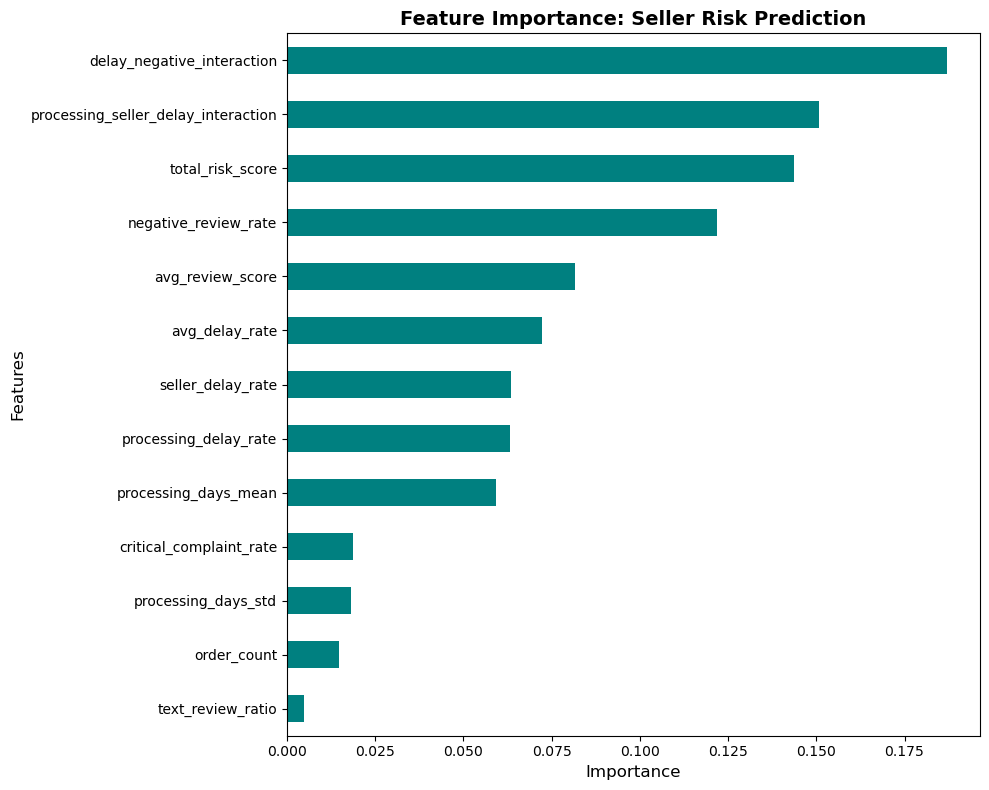

피처 중요도 Top 5
1. delay_negative_interaction: 0.1870
2. processing_seller_delay_interaction: 0.1509
3. total_risk_score: 0.1437
4. negative_review_rate: 0.1219
5. avg_review_score: 0.0816


In [59]:
# 피처 중요도 추출
importances = pd.Series(model.feature_importances_, index=feature_13)
importances = importances.sort_values(ascending=True)

# 시각화
plt.figure(figsize=(10, 8))
importances.plot(kind='barh', color='teal')
plt.title('Feature Importance: Seller Risk Prediction', fontsize=14, fontweight='bold')
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.tight_layout()
plt.show()

print("="*80)
print("피처 중요도 Top 5")
print("="*80)
for idx, (feat, imp) in enumerate(importances.sort_values(ascending=False).head(5).items(), 1):
    print(f"{idx}. {feat}: {imp:.4f}")
